In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

SR = 44100
blocksize = 88200
overlap = 44100

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 2.8675105571746826
(1506, 1, 88200)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', fmin=800, fmax=8000, sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

________________________________________________________________________________
Layer (type)              Output Shape              Param #     
melspectrogram_1 (Melspec (None, 128, 345, 1)       296064      
Total params: 296,064
Trainable params: 0
Non-trainable params: 296,064
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 5s 2s/step - loss: 1462.9301
(1, 88200)


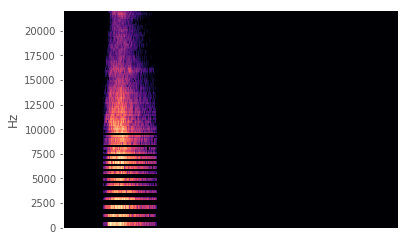

(1506, 128, 345)


In [16]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))
model = Sequential()
model.add(Melspectrogram(
    sr=44100,
    n_mels=128,
    power_melgram=2.0,
    return_decibel_melgram = True,
    input_shape=(1, blocksize),
    trainable_fb=False,
    fmin = 800,
    fmax = 8000
))

check_model(model)
visualise_model(model, c_data[1])
mfccs = evaluate_model(model, c_data)
n_targets = np.repeat(targets, mfccs.shape[1])
cat_targets = np.repeat(c_targets, mfccs.shape[1])

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(1506, 128, 345, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 337, 32)      2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 19, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                77856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

1023/1023 [==============================] - 5s 5ms/step - loss: 0.3987 - acc: 0.8133 - mean_absolute_error: 0.2831 - val_loss: 0.7403 - val_acc: 0.7182 - val_mean_absolute_error: 0.3472
Epoch 36/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.3898 - acc: 0.8192 - mean_absolute_error: 0.2721 - val_loss: 0.6614 - val_acc: 0.7127 - val_mean_absolute_error: 0.3585
Epoch 37/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.3943 - acc: 0.8143 - mean_absolute_error: 0.2723 - val_loss: 0.6781 - val_acc: 0.7072 - val_mean_absolute_error: 0.3615
Epoch 38/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.3858 - acc: 0.8201 - mean_absolute_error: 0.2701 - val_loss: 0.7092 - val_acc: 0.7127 - val_mean_absolute_error: 0.3511
Epoch 39/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.3833 - acc: 0.8328 - mean_absolute_error: 0.2669 - val_loss: 0.7055 - val_acc: 0.7127 - val_mean_absolute_error: 0.3473
Epoch 40/100


1023/1023 [==============================] - 5s 5ms/step - loss: 0.2343 - acc: 0.8847 - mean_absolute_error: 0.1664 - val_loss: 0.7930 - val_acc: 0.7403 - val_mean_absolute_error: 0.3057
Epoch 77/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.2359 - acc: 0.8983 - mean_absolute_error: 0.1663 - val_loss: 0.8377 - val_acc: 0.7403 - val_mean_absolute_error: 0.2966
Epoch 78/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.2233 - acc: 0.9062 - mean_absolute_error: 0.1636 - val_loss: 0.8664 - val_acc: 0.7293 - val_mean_absolute_error: 0.2949
Epoch 79/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.2273 - acc: 0.8895 - mean_absolute_error: 0.1610 - val_loss: 0.7870 - val_acc: 0.7293 - val_mean_absolute_error: 0.3011
Epoch 80/100
1023/1023 [==============================] - 5s 5ms/step - loss: 0.2147 - acc: 0.9052 - mean_absolute_error: 0.1579 - val_loss: 0.8365 - val_acc: 0.7293 - val_mean_absolute_error: 0.2891
Epoch 81/100


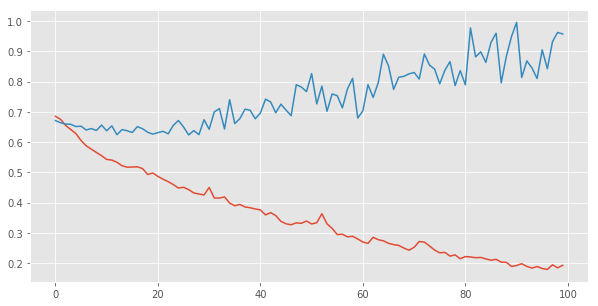

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

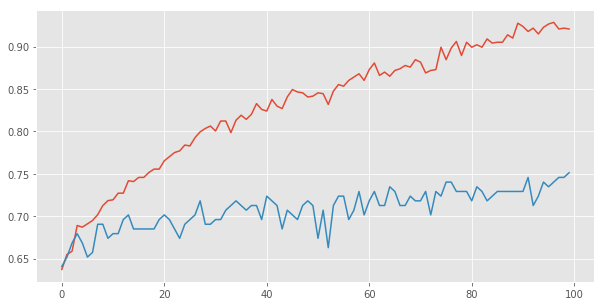

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.7781456953642384
Confusion matrix, without normalization
[[ 77  49]
 [ 18 158]]


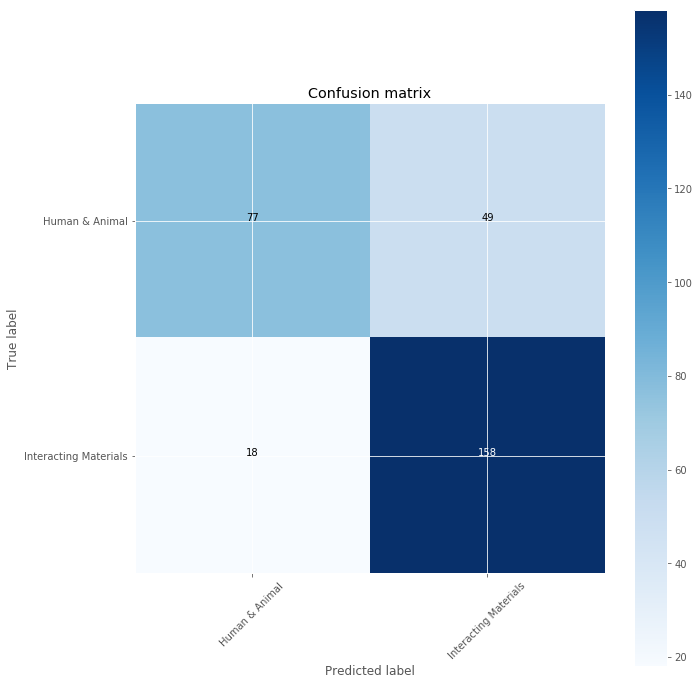

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 343, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 20, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               409728    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

383/383 [==============================] - 2s 5ms/step - loss: 2.9139 - acc: 0.0574 - mean_absolute_error: 0.0994 - val_loss: 2.9480 - val_acc: 0.0441 - val_mean_absolute_error: 0.0996
Epoch 32/200
383/383 [==============================] - 2s 5ms/step - loss: 2.9045 - acc: 0.0653 - mean_absolute_error: 0.0993 - val_loss: 2.9373 - val_acc: 0.0441 - val_mean_absolute_error: 0.0995
Epoch 33/200
383/383 [==============================] - 2s 5ms/step - loss: 2.9016 - acc: 0.0601 - mean_absolute_error: 0.0993 - val_loss: 2.9176 - val_acc: 0.0588 - val_mean_absolute_error: 0.0995
Epoch 34/200
383/383 [==============================] - 2s 5ms/step - loss: 2.8843 - acc: 0.0809 - mean_absolute_error: 0.0993 - val_loss: 2.9039 - val_acc: 0.0735 - val_mean_absolute_error: 0.0993
Epoch 35/200
383/383 [==============================] - 2s 5ms/step - loss: 2.8791 - acc: 0.0809 - mean_absolute_error: 0.0991 - val_loss: 2.8838 - val_acc: 0.0735 - val_mean_absolute_error: 0.0991
Epoch 36/200
383/383 [=

383/383 [==============================] - 2s 4ms/step - loss: 2.7206 - acc: 0.1332 - mean_absolute_error: 0.0971 - val_loss: 2.7628 - val_acc: 0.2059 - val_mean_absolute_error: 0.0971
Epoch 73/200
383/383 [==============================] - 2s 5ms/step - loss: 2.7498 - acc: 0.1175 - mean_absolute_error: 0.0972 - val_loss: 2.6429 - val_acc: 0.1765 - val_mean_absolute_error: 0.0958
Epoch 74/200
383/383 [==============================] - 2s 5ms/step - loss: 2.6945 - acc: 0.1619 - mean_absolute_error: 0.0962 - val_loss: 2.6269 - val_acc: 0.1765 - val_mean_absolute_error: 0.0950
Epoch 75/200
383/383 [==============================] - 2s 5ms/step - loss: 2.6631 - acc: 0.1279 - mean_absolute_error: 0.0961 - val_loss: 2.6416 - val_acc: 0.2206 - val_mean_absolute_error: 0.0957
Epoch 76/200
383/383 [==============================] - 2s 5ms/step - loss: 2.6587 - acc: 0.1410 - mean_absolute_error: 0.0961 - val_loss: 2.6055 - val_acc: 0.2206 - val_mean_absolute_error: 0.0947
Epoch 77/200
383/383 [=

383/383 [==============================] - 2s 4ms/step - loss: 2.4310 - acc: 0.1958 - mean_absolute_error: 0.0915 - val_loss: 2.4335 - val_acc: 0.2941 - val_mean_absolute_error: 0.0902
Epoch 114/200
383/383 [==============================] - 2s 4ms/step - loss: 2.4210 - acc: 0.1880 - mean_absolute_error: 0.0914 - val_loss: 2.3897 - val_acc: 0.2647 - val_mean_absolute_error: 0.0897
Epoch 115/200
383/383 [==============================] - 2s 5ms/step - loss: 2.3978 - acc: 0.2037 - mean_absolute_error: 0.0910 - val_loss: 2.3814 - val_acc: 0.2647 - val_mean_absolute_error: 0.0896
Epoch 116/200
383/383 [==============================] - 2s 5ms/step - loss: 2.3938 - acc: 0.1775 - mean_absolute_error: 0.0912 - val_loss: 2.3981 - val_acc: 0.2794 - val_mean_absolute_error: 0.0890
Epoch 117/200
383/383 [==============================] - 2s 5ms/step - loss: 2.3867 - acc: 0.2193 - mean_absolute_error: 0.0903 - val_loss: 2.3994 - val_acc: 0.2059 - val_mean_absolute_error: 0.0901
Epoch 118/200
383/3

383/383 [==============================] - 2s 4ms/step - loss: 2.3340 - acc: 0.2141 - mean_absolute_error: 0.0890 - val_loss: 2.3898 - val_acc: 0.2206 - val_mean_absolute_error: 0.0891
Epoch 155/200
383/383 [==============================] - 2s 4ms/step - loss: 2.3496 - acc: 0.1906 - mean_absolute_error: 0.0907 - val_loss: 2.3192 - val_acc: 0.2647 - val_mean_absolute_error: 0.0876
Epoch 156/200
383/383 [==============================] - 2s 4ms/step - loss: 2.2821 - acc: 0.2037 - mean_absolute_error: 0.0887 - val_loss: 2.3998 - val_acc: 0.2647 - val_mean_absolute_error: 0.0875
Epoch 157/200
383/383 [==============================] - 2s 4ms/step - loss: 2.2436 - acc: 0.2324 - mean_absolute_error: 0.0886 - val_loss: 2.3574 - val_acc: 0.2941 - val_mean_absolute_error: 0.0875
Epoch 158/200
383/383 [==============================] - 2s 5ms/step - loss: 2.2533 - acc: 0.2115 - mean_absolute_error: 0.0883 - val_loss: 2.3232 - val_acc: 0.3088 - val_mean_absolute_error: 0.0869
Epoch 159/200
383/3

383/383 [==============================] - 2s 4ms/step - loss: 2.2177 - acc: 0.2585 - mean_absolute_error: 0.0857 - val_loss: 2.3607 - val_acc: 0.2794 - val_mean_absolute_error: 0.0868
Epoch 196/200
383/383 [==============================] - 2s 4ms/step - loss: 2.1984 - acc: 0.2402 - mean_absolute_error: 0.0876 - val_loss: 2.3664 - val_acc: 0.2647 - val_mean_absolute_error: 0.0854
Epoch 197/200
383/383 [==============================] - 2s 4ms/step - loss: 2.0820 - acc: 0.2611 - mean_absolute_error: 0.0845 - val_loss: 2.3819 - val_acc: 0.2794 - val_mean_absolute_error: 0.0844
Epoch 198/200
383/383 [==============================] - 2s 5ms/step - loss: 2.0874 - acc: 0.2533 - mean_absolute_error: 0.0846 - val_loss: 2.4107 - val_acc: 0.2794 - val_mean_absolute_error: 0.0865
Epoch 199/200
383/383 [==============================] - 2s 4ms/step - loss: 2.1356 - acc: 0.2350 - mean_absolute_error: 0.0862 - val_loss: 2.3727 - val_acc: 0.2647 - val_mean_absolute_error: 0.0853
Epoch 200/200
383/3

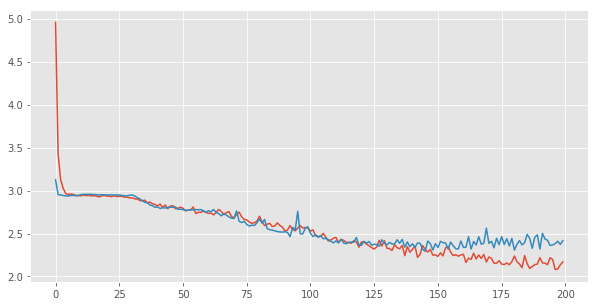

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

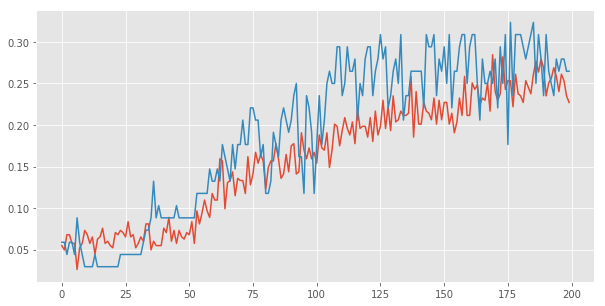

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.18584070796460178
Confusion matrix, without normalization
[[0 0 0 2 0 0 1 1 0 0 1 0 0 0 0 0 0 3 0]
 [0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 4 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 1 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 6 0 2 0 0 0 0 0 0]
 [0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 2 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 5 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 2 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 1 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 3 0 2 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 1 0 5 0 0 0 0 0 0 0 0]
 [0 0 2 2 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 4 0 0 0 1 0 0 0 0]]


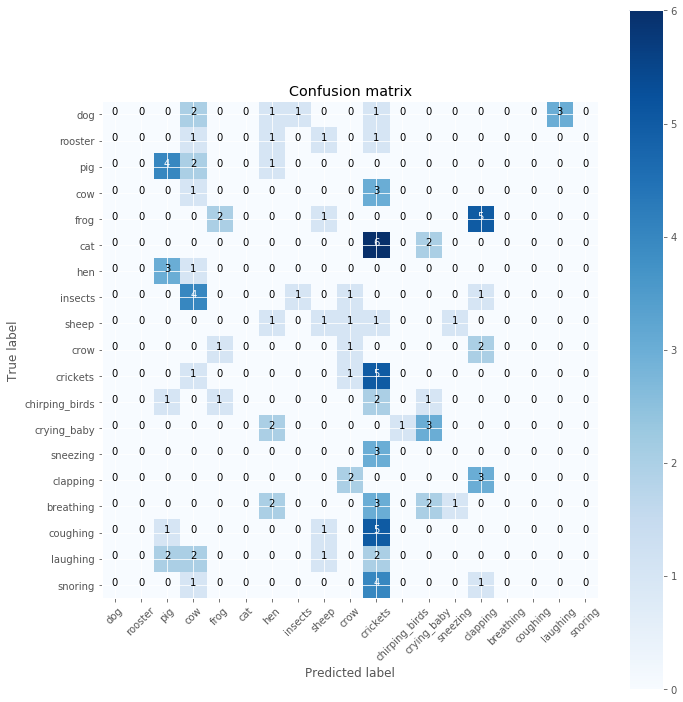

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, blocksize),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 345, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 343, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 20, 16)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 19, 32)         5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               77952     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

640/640 [==============================] - 3s 4ms/step - loss: 2.5460 - acc: 0.1938 - mean_absolute_error: 0.0569 - val_loss: 2.6562 - val_acc: 0.2035 - val_mean_absolute_error: 0.0568
Epoch 32/200
640/640 [==============================] - 3s 4ms/step - loss: 2.5482 - acc: 0.2000 - mean_absolute_error: 0.0571 - val_loss: 2.7101 - val_acc: 0.1858 - val_mean_absolute_error: 0.0570
Epoch 33/200
640/640 [==============================] - 3s 4ms/step - loss: 2.6572 - acc: 0.1750 - mean_absolute_error: 0.0572 - val_loss: 2.6973 - val_acc: 0.1593 - val_mean_absolute_error: 0.0572
Epoch 34/200
640/640 [==============================] - 3s 4ms/step - loss: 2.5852 - acc: 0.1891 - mean_absolute_error: 0.0574 - val_loss: 2.7085 - val_acc: 0.1327 - val_mean_absolute_error: 0.0576
Epoch 35/200
640/640 [==============================] - 3s 4ms/step - loss: 2.4928 - acc: 0.1953 - mean_absolute_error: 0.0569 - val_loss: 2.6353 - val_acc: 0.1327 - val_mean_absolute_error: 0.0567
Epoch 36/200
640/640 [=

640/640 [==============================] - 3s 4ms/step - loss: 1.7278 - acc: 0.3922 - mean_absolute_error: 0.0476 - val_loss: 2.2030 - val_acc: 0.3097 - val_mean_absolute_error: 0.0500
Epoch 73/200
640/640 [==============================] - 3s 4ms/step - loss: 1.6597 - acc: 0.3906 - mean_absolute_error: 0.0463 - val_loss: 2.1683 - val_acc: 0.3451 - val_mean_absolute_error: 0.0493
Epoch 74/200
640/640 [==============================] - 3s 4ms/step - loss: 1.6289 - acc: 0.4062 - mean_absolute_error: 0.0451 - val_loss: 2.1940 - val_acc: 0.3274 - val_mean_absolute_error: 0.0483
Epoch 75/200
640/640 [==============================] - 3s 4ms/step - loss: 1.6759 - acc: 0.3922 - mean_absolute_error: 0.0462 - val_loss: 2.0941 - val_acc: 0.3628 - val_mean_absolute_error: 0.0479
Epoch 76/200
640/640 [==============================] - 3s 4ms/step - loss: 1.6056 - acc: 0.4547 - mean_absolute_error: 0.0451 - val_loss: 2.0594 - val_acc: 0.3894 - val_mean_absolute_error: 0.0469
Epoch 77/200
640/640 [=

640/640 [==============================] - 3s 4ms/step - loss: 1.1448 - acc: 0.5641 - mean_absolute_error: 0.0358 - val_loss: 2.4583 - val_acc: 0.3628 - val_mean_absolute_error: 0.0456
Epoch 114/200
640/640 [==============================] - 3s 4ms/step - loss: 1.2186 - acc: 0.5547 - mean_absolute_error: 0.0362 - val_loss: 2.2353 - val_acc: 0.3628 - val_mean_absolute_error: 0.0439
Epoch 115/200
640/640 [==============================] - 3s 4ms/step - loss: 1.1691 - acc: 0.6109 - mean_absolute_error: 0.0357 - val_loss: 2.2791 - val_acc: 0.3540 - val_mean_absolute_error: 0.0451
Epoch 116/200
640/640 [==============================] - 3s 4ms/step - loss: 1.2328 - acc: 0.5500 - mean_absolute_error: 0.0369 - val_loss: 2.1605 - val_acc: 0.3363 - val_mean_absolute_error: 0.0452
Epoch 117/200
640/640 [==============================] - 3s 4ms/step - loss: 1.1790 - acc: 0.5578 - mean_absolute_error: 0.0361 - val_loss: 2.2100 - val_acc: 0.3894 - val_mean_absolute_error: 0.0436
Epoch 118/200
640/6

640/640 [==============================] - 3s 4ms/step - loss: 0.8279 - acc: 0.7062 - mean_absolute_error: 0.0271 - val_loss: 2.5747 - val_acc: 0.3805 - val_mean_absolute_error: 0.0421
Epoch 155/200
640/640 [==============================] - 3s 4ms/step - loss: 0.8559 - acc: 0.6922 - mean_absolute_error: 0.0274 - val_loss: 2.5635 - val_acc: 0.4513 - val_mean_absolute_error: 0.0410
Epoch 156/200
640/640 [==============================] - 3s 4ms/step - loss: 0.8057 - acc: 0.7156 - mean_absolute_error: 0.0269 - val_loss: 2.4881 - val_acc: 0.4071 - val_mean_absolute_error: 0.0418
Epoch 157/200
640/640 [==============================] - 3s 4ms/step - loss: 0.7513 - acc: 0.7203 - mean_absolute_error: 0.0257 - val_loss: 2.5691 - val_acc: 0.4425 - val_mean_absolute_error: 0.0412
Epoch 158/200
640/640 [==============================] - 3s 4ms/step - loss: 0.8331 - acc: 0.6922 - mean_absolute_error: 0.0265 - val_loss: 2.6389 - val_acc: 0.3717 - val_mean_absolute_error: 0.0419
Epoch 159/200
640/6

640/640 [==============================] - 3s 4ms/step - loss: 0.7000 - acc: 0.7547 - mean_absolute_error: 0.0230 - val_loss: 2.7221 - val_acc: 0.4336 - val_mean_absolute_error: 0.0401
Epoch 196/200
640/640 [==============================] - 3s 4ms/step - loss: 0.6844 - acc: 0.7609 - mean_absolute_error: 0.0227 - val_loss: 2.6640 - val_acc: 0.4336 - val_mean_absolute_error: 0.0420
Epoch 197/200
640/640 [==============================] - 3s 4ms/step - loss: 0.7525 - acc: 0.7469 - mean_absolute_error: 0.0237 - val_loss: 2.8721 - val_acc: 0.4336 - val_mean_absolute_error: 0.0411
Epoch 198/200
640/640 [==============================] - 3s 4ms/step - loss: 0.5975 - acc: 0.7891 - mean_absolute_error: 0.0212 - val_loss: 2.6994 - val_acc: 0.4159 - val_mean_absolute_error: 0.0400
Epoch 199/200
640/640 [==============================] - 3s 4ms/step - loss: 0.5900 - acc: 0.7969 - mean_absolute_error: 0.0203 - val_loss: 2.7984 - val_acc: 0.4248 - val_mean_absolute_error: 0.0398
Epoch 200/200
640/6

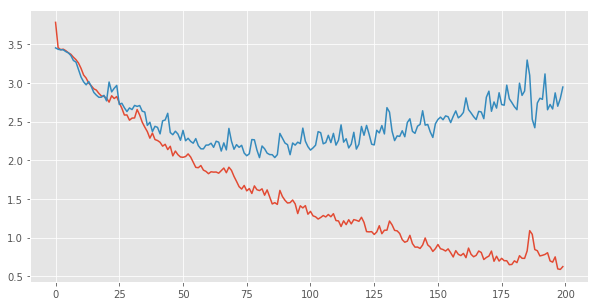

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

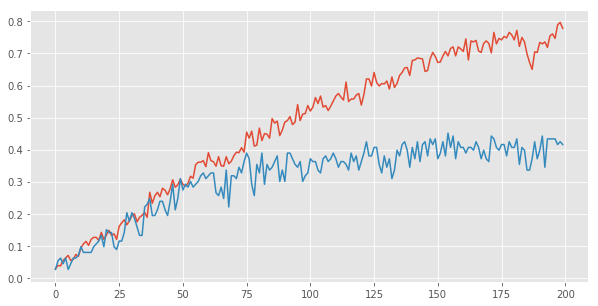

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.4074074074074074
Confusion matrix, without normalization
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0 0]
 [0 0 7 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 2 0 1 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 2 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 3 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 2

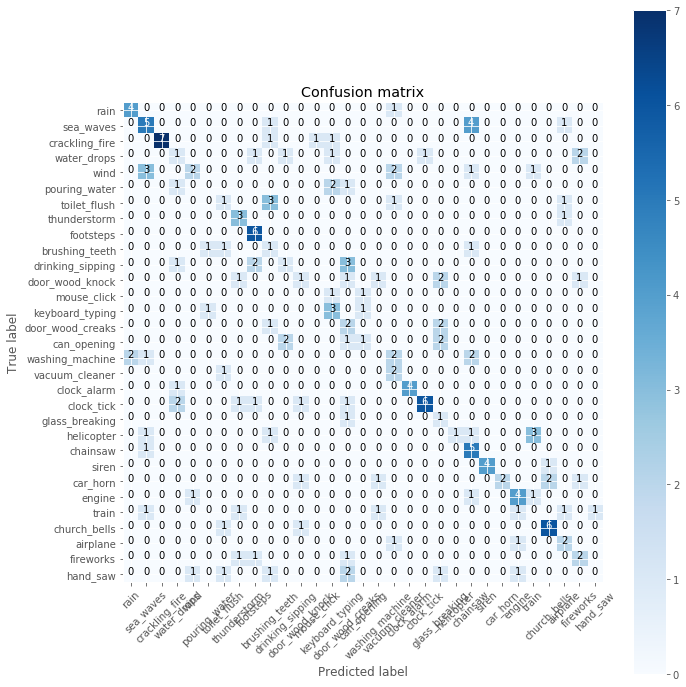

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 2.980053663253784
	Processing Time: 2.869342088699341
	Processing Time: 2.8485705852508545
	Processing Time: 2.913893461227417


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(6058, 1, 88200)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(6058,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(6058,)


0.7330802244965335
Confusion matrix, without normalization
[[1125 1153]
 [ 464 3316]]


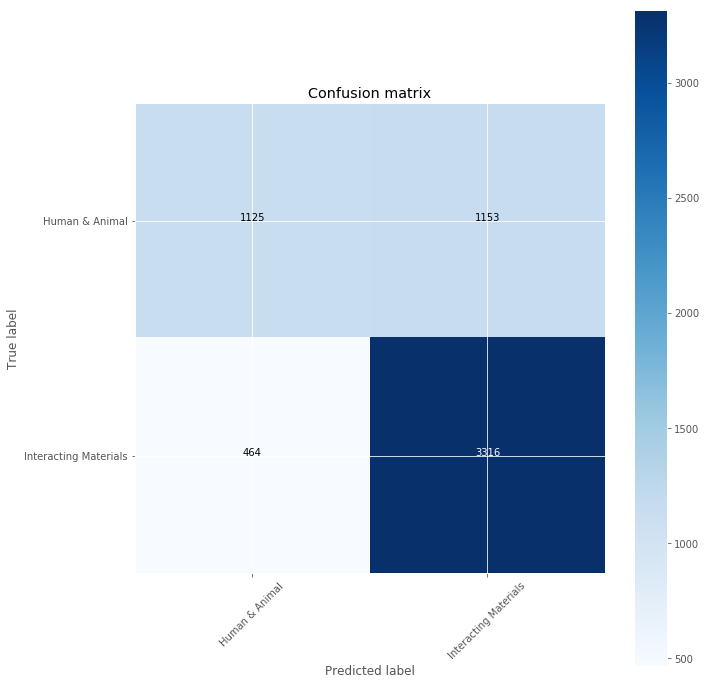

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.16417910447761194
Confusion matrix, without normalization
[[  0   0   4  20   1  14   7   3   2   1  36   1  13   1   9   0   0   8
    0]
 [  0   0  10  11   0   4   6   0   7   5  52   2   8   0  10   0   0   0
    0]
 [  0   0  26  18   3   1   5   0   1   5   7   2   1   1  43   0   0   1
    0]
 [  0   0  23  33   0   5  12   0   2   4  24   1   6   0   7   0   0   2
    0]
 [  0   0   1   5  32   2   1   0  18  13  16   1   0   0  37   0   0   2
    0]
 [  0   0   7   1   2   7   3   0   3   2  69   4   7   5   2   0   0   0
    0]
 [  0   0  25   5   0  12  22   0   0   2  20   0  31   0   1   0   0   5
    0]
 [  0   0   6  28   0   8   3   0   2   7  51   2   4   1   9   0   0   4
    0]
 [  0   0   3  12  18   3   0   0  15  28  15   8   1   5  17   0   0   3
    0]
 [  0   0   6  11  19   1   0   1   6  27  16   2   0   2  30   0   0   0
    0]
 [  0   0   7  13   8   6   0   0   9   7  51   0  26   0   1   0   0   0
    0]
 [  0   0  20   7   6   6   4   1  20   5  40   8

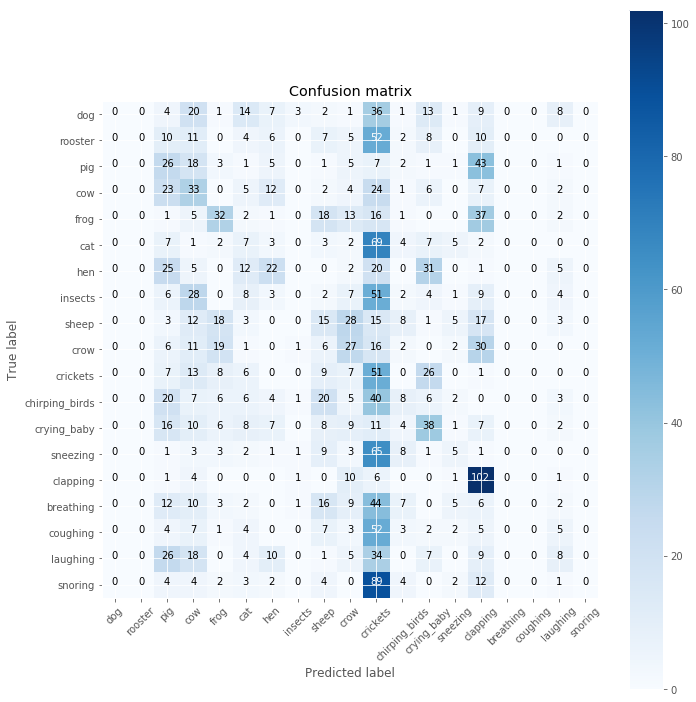

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.19894179894179895
Confusion matrix, without normalization
[[36 17  1  0  2  0  4  0  0  2  0  0  0  0  0  0  2 25  0  0  0 17 12  0
   0  1  2  0  6  0  1]
 [ 0 35  0  0  2  0 31  0  0  4  0  0  0  0  0  0  2 12  1  0  1  1 28  0
   0  5  1  0  3  0  2]
 [ 1  1 54  3  9 21  0  0  2  2  1  0 12 13  0  0  0  1  1  0  4  0  0  0
   0  2  0  0  0  0  0]
 [ 0  0  2 18  0  9  0  2  2  0 19  6  9  8  4  2  0  0  3  6 12  0  0  0
   0  3  0  1  2  5  0]
 [ 0  7  0  0 24  0  0 13  3  0  0  0  0  0  0  0  0  0  0  0  0  9  9 15
   0 14 22  2  8  0  2]
 [ 0  0  7  6  0 41  0  0  5  1  3  2  1 19 13  0  0  0  7  0 11  0  0  1
   3  1  0  0  0  0  5]
 [15  4  0  0  6  2 28  0  0 17  1  5  0  0  5  0  4  5  6  0  0  2  7  0
   0  4  0  0  1  1 15]
 [ 0  0  0  1  4  0  0 43  1  0  0  1  2  0  0  0  0  0  0  0  0  1  1 14
   1  4  1 11 35  8  0]
 [ 1  5 10  0  5  5  0  2 13 14  4  3  0  1  2  0  0  0  0  0  0  3  3  0
   5 14  4  0  0  8 24]
 [ 0  4  9  1 17  0  8  0 11 15  0  2  2  2  2  0  0  0  2

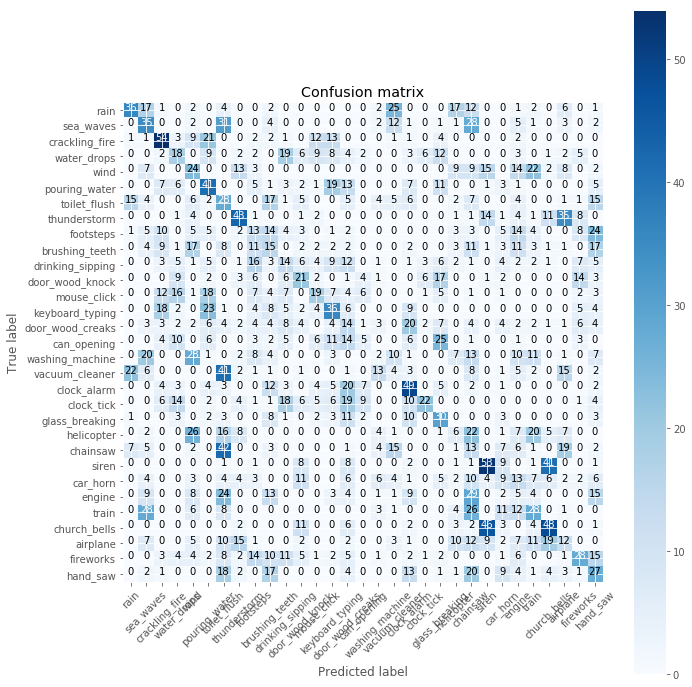

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 5.5732740e-31],
       [2.4439096e-02, 9.7556090e-01],
       ...,
       [1.1098385e-04, 9.9988902e-01],
       [6.1677158e-02, 9.3832284e-01],
       [3.8070935e-01, 6.1929065e-01]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.021357297897338867


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

4/4 [==============================] - 0s 3ms/step


In [49]:
np.average(pred_prob, axis=0)

array([0.51572764, 0.48427236], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

4/4 [==============================] - 0s 3ms/step


In [51]:
np.average(pred_prob, axis=0)

array([2.0363598e-07, 1.3652589e-02, 2.5282946e-01, 8.0764424e-03,
       2.0938388e-01, 5.2444477e-07, 1.1956900e-02, 1.9652922e-02,
       5.1286265e-02, 2.5179869e-01, 2.9583779e-07, 1.8009756e-02,
       6.2792322e-05, 4.9510618e-07, 1.6171104e-01, 2.7110102e-04,
       7.3431338e-06, 1.2992558e-03, 9.0638366e-08], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

9


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [54]:
predictions = []
full_targets = []
start_time = time.time()
top_pred_probs = []
pred_probs = []

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    top_pred_probs.append(clas.predict_proba(x_file))
    prob = np.average(top_pred_probs[-1], axis=0)
    if prob[0] > 0.5:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(anim.predict_proba(x_file))
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
        pred_probs.append(inter.predict_proba(x_file))
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.006120920181274414
	Processing Time: 0.0051190853118896484
	Processing Time: 0.004024982452392578
	Processing Time: 0.0045392513275146484
	Processing Time: 0.005552530288696289
	Processing Time: 0.0041904449462890625
	Processing Time: 0.0047130584716796875
	Processing Time: 0.005033016204833984
	Processing Time: 0.00621342658996582
	Processing Time: 0.005494356155395508
	Processing Time: 0.0046977996826171875
	Processing Time: 0.0047359466552734375
	Processing Time: 0.005520343780517578
	Processing Time: 0.003991842269897461
	Processing Time: 0.0036745071411132812
	Processing Time: 0.004010915756225586
	Processing Time: 0.006962299346923828
	Processing Time: 0.006353855133056641
	Processing Time: 0.004621982574462891
	Processing Time: 0.0059528350830078125
	Processing Time: 0.004921436309814453
	Processing Time: 0.004165172576904297
	Processing Time: 0.004159688949584961
	Processing Time: 0.004160165786743164
	Processing Time: 0.004140138626098633
	Processing Time: 

	Processing Time: 0.0040645599365234375
	Processing Time: 0.004303693771362305
	Processing Time: 0.004040718078613281
	Processing Time: 0.0038492679595947266
	Processing Time: 0.00418853759765625
	Processing Time: 0.004067897796630859
	Processing Time: 0.004057645797729492
	Processing Time: 0.0040204524993896484
	Processing Time: 0.004037141799926758
	Processing Time: 0.004040241241455078
	Processing Time: 0.004031181335449219
	Processing Time: 0.004033088684082031
	Processing Time: 0.004032135009765625
	Processing Time: 0.004023313522338867
	Processing Time: 0.004018306732177734
	Processing Time: 0.003937721252441406
	Processing Time: 0.003977060317993164
	Processing Time: 0.004038572311401367
	Processing Time: 0.004019975662231445
	Processing Time: 0.004044294357299805
	Processing Time: 0.004038810729980469
	Processing Time: 0.0047359466552734375
	Processing Time: 0.00401616096496582
	Processing Time: 0.0040204524993896484
	Processing Time: 0.004022836685180664
	Processing Time: 0.00

	Processing Time: 0.00402069091796875
	Processing Time: 0.003990888595581055
	Processing Time: 0.003982067108154297
	Processing Time: 0.003970146179199219
	Processing Time: 0.0039861202239990234
	Processing Time: 0.003979921340942383
	Processing Time: 0.003996372222900391
	Processing Time: 0.003996372222900391
	Processing Time: 0.003988504409790039
	Processing Time: 0.003968954086303711
	Processing Time: 0.003991365432739258
	Processing Time: 0.004003047943115234
	Processing Time: 0.004171609878540039
	Processing Time: 0.00400233268737793
	Processing Time: 0.003985881805419922
	Processing Time: 0.003998994827270508
	Processing Time: 0.00399017333984375
	Processing Time: 0.0039675235748291016
	Processing Time: 0.003997087478637695
	Processing Time: 0.003993034362792969
	Processing Time: 0.004012107849121094
	Processing Time: 0.003983736038208008
	Processing Time: 0.0039823055267333984
	Processing Time: 0.003972291946411133
	Processing Time: 0.00397944450378418
	Processing Time: 0.003983

	Processing Time: 0.004308223724365234
	Processing Time: 0.003992557525634766
	Processing Time: 0.003968238830566406
	Processing Time: 0.003978729248046875
	Processing Time: 0.00395655632019043
	Processing Time: 0.003977298736572266
	Processing Time: 0.003972530364990234
	Processing Time: 0.003997087478637695
	Processing Time: 0.0039708614349365234
	Processing Time: 0.003762483596801758
	Processing Time: 0.00396418571472168
	Processing Time: 0.0039942264556884766
	Processing Time: 0.0042040348052978516
	Processing Time: 0.003992319107055664
	Processing Time: 0.0039637088775634766
	Processing Time: 0.003976583480834961
	Processing Time: 0.003979682922363281
	Processing Time: 0.003981590270996094
	Processing Time: 0.0038785934448242188
	Processing Time: 0.0039517879486083984
	Processing Time: 0.0046236515045166016
	Processing Time: 0.003975391387939453
	Processing Time: 0.00397801399230957
	Processing Time: 0.003972053527832031
	Processing Time: 0.003948211669921875
	Processing Time: 0.0

	Processing Time: 0.0050089359283447266
	Processing Time: 0.00404667854309082
	Processing Time: 0.0040340423583984375
	Processing Time: 0.004004001617431641
	Processing Time: 0.004012107849121094
	Processing Time: 0.003992795944213867
	Processing Time: 0.003988981246948242
	Processing Time: 0.004011392593383789
	Processing Time: 0.00397801399230957
	Processing Time: 0.003993988037109375
	Processing Time: 0.0040051937103271484
	Processing Time: 0.00397181510925293
	Processing Time: 0.004164934158325195
	Processing Time: 0.004001617431640625
	Processing Time: 0.004022359848022461
	Processing Time: 0.0040051937103271484
	Processing Time: 0.004035472869873047
	Processing Time: 0.004014730453491211
	Processing Time: 0.004019737243652344
	Processing Time: 0.004003286361694336
	Processing Time: 0.004044771194458008
	Processing Time: 0.0040531158447265625
	Processing Time: 0.004029512405395508
	Processing Time: 0.003791332244873047
	Processing Time: 0.004035472869873047
	Processing Time: 0.004

	Processing Time: 0.0048389434814453125
	Processing Time: 0.003985404968261719
	Processing Time: 0.0039479732513427734
	Processing Time: 0.00398707389831543
	Processing Time: 0.003988742828369141
	Processing Time: 0.0037736892700195312
	Processing Time: 0.003988027572631836
	Processing Time: 0.004667758941650391
	Processing Time: 0.0039827823638916016
	Processing Time: 0.003993034362792969
	Processing Time: 0.003999233245849609
	Processing Time: 0.0039746761322021484
	Processing Time: 0.003985881805419922
	Processing Time: 0.003921031951904297
	Processing Time: 0.004651784896850586
	Processing Time: 0.003778696060180664
	Processing Time: 0.0037910938262939453
	Processing Time: 0.004009723663330078
	Processing Time: 0.004017353057861328
	Processing Time: 0.004142284393310547
	Processing Time: 0.004164218902587891
	Processing Time: 0.0041391849517822266
	Processing Time: 0.0041332244873046875
	Processing Time: 0.004174709320068359
	Processing Time: 0.004140377044677734
	Processing Time: 

	Processing Time: 0.004457235336303711
	Processing Time: 0.004003286361694336
	Processing Time: 0.0040018558502197266
	Processing Time: 0.0040225982666015625
	Processing Time: 0.0040264129638671875
	Processing Time: 0.0040073394775390625
	Processing Time: 0.004004001617431641
	Processing Time: 0.003793478012084961
	Processing Time: 0.0040051937103271484
	Processing Time: 0.0044023990631103516
	Processing Time: 0.004010200500488281
	Processing Time: 0.00400996208190918
	Processing Time: 0.004004001617431641
	Processing Time: 0.004961490631103516
	Processing Time: 0.003991127014160156
	Processing Time: 0.0038766860961914062
	Processing Time: 0.003983974456787109
	Processing Time: 0.003980159759521484
	Processing Time: 0.003977537155151367
	Processing Time: 0.0039865970611572266
	Processing Time: 0.004587888717651367
	Processing Time: 0.003981828689575195
	Processing Time: 0.003966331481933594
	Processing Time: 0.0039556026458740234
	Processing Time: 0.003958940505981445
	Processing Time:

	Processing Time: 0.004115104675292969
	Processing Time: 0.004126071929931641
	Processing Time: 0.003859281539916992
	Processing Time: 0.0039975643157958984
	Processing Time: 0.004014015197753906
	Processing Time: 0.004006862640380859
	Processing Time: 0.004023075103759766
	Processing Time: 0.004000186920166016
	Processing Time: 0.004004955291748047
	Processing Time: 0.0040094852447509766
	Processing Time: 0.0039980411529541016
	Processing Time: 0.004014015197753906
	Processing Time: 0.00399470329284668
	Processing Time: 0.003998279571533203
	Processing Time: 0.003995180130004883
	Processing Time: 0.003995656967163086
	Processing Time: 0.004035234451293945
	Processing Time: 0.003893136978149414
	Processing Time: 0.0040018558502197266
	Processing Time: 0.004051923751831055
	Processing Time: 0.0040111541748046875
	Processing Time: 0.003991842269897461
	Processing Time: 0.004009246826171875
	Processing Time: 0.003985166549682617
	Processing Time: 0.004007101058959961
	Processing Time: 0.0

	Processing Time: 0.004052639007568359
	Processing Time: 0.004021406173706055
	Processing Time: 0.004036426544189453
	Processing Time: 0.004026174545288086
	Processing Time: 0.004045724868774414
	Processing Time: 0.00409245491027832
	Processing Time: 0.004029512405395508
	Processing Time: 0.004023551940917969
	Processing Time: 0.0040357112884521484
	Processing Time: 0.004029989242553711
	Processing Time: 0.004051685333251953
	Processing Time: 0.004019021987915039
	Processing Time: 0.004016399383544922
	Processing Time: 0.004009723663330078
	Processing Time: 0.0040128231048583984
	Processing Time: 0.004014730453491211
	Processing Time: 0.003997087478637695
	Processing Time: 0.004004716873168945
	Processing Time: 0.003992557525634766
	Processing Time: 0.004009723663330078
	Processing Time: 0.004034280776977539
	Processing Time: 0.003973960876464844
	Processing Time: 0.004015207290649414
	Processing Time: 0.004030704498291016
	Processing Time: 0.003976106643676758
	Processing Time: 0.0040

	Processing Time: 0.004058122634887695
	Processing Time: 0.0039250850677490234
	Processing Time: 0.004041910171508789
	Processing Time: 0.004032611846923828
	Processing Time: 0.00404047966003418
	Processing Time: 0.004050493240356445
	Processing Time: 0.0040814876556396484
	Processing Time: 0.0038957595825195312
	Processing Time: 0.004163503646850586
	Processing Time: 0.004010677337646484
	Processing Time: 0.004027843475341797
	Processing Time: 0.003979682922363281
	Processing Time: 0.004044771194458008
	Processing Time: 0.0040283203125
	Processing Time: 0.004861354827880859
	Processing Time: 0.0039730072021484375
	Processing Time: 0.0039942264556884766
	Processing Time: 0.003972768783569336
	Processing Time: 0.004033803939819336
	Processing Time: 0.004006862640380859
	Processing Time: 0.004000663757324219
	Processing Time: 0.004022121429443359
	Processing Time: 0.004015207290649414
	Processing Time: 0.004011869430541992
	Processing Time: 0.0040013790130615234
	Processing Time: 0.00400

In [55]:
targs = np.vstack(full_targets)

0.1125
Confusion matrix, without normalization
[[ 0  0  2 ...  0  1  0]
 [ 0  0  7 ...  0  1  0]
 [ 0  0 11 ...  0  1  3]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  2 11  9]
 [ 0  0  0 ...  0  0  1]]


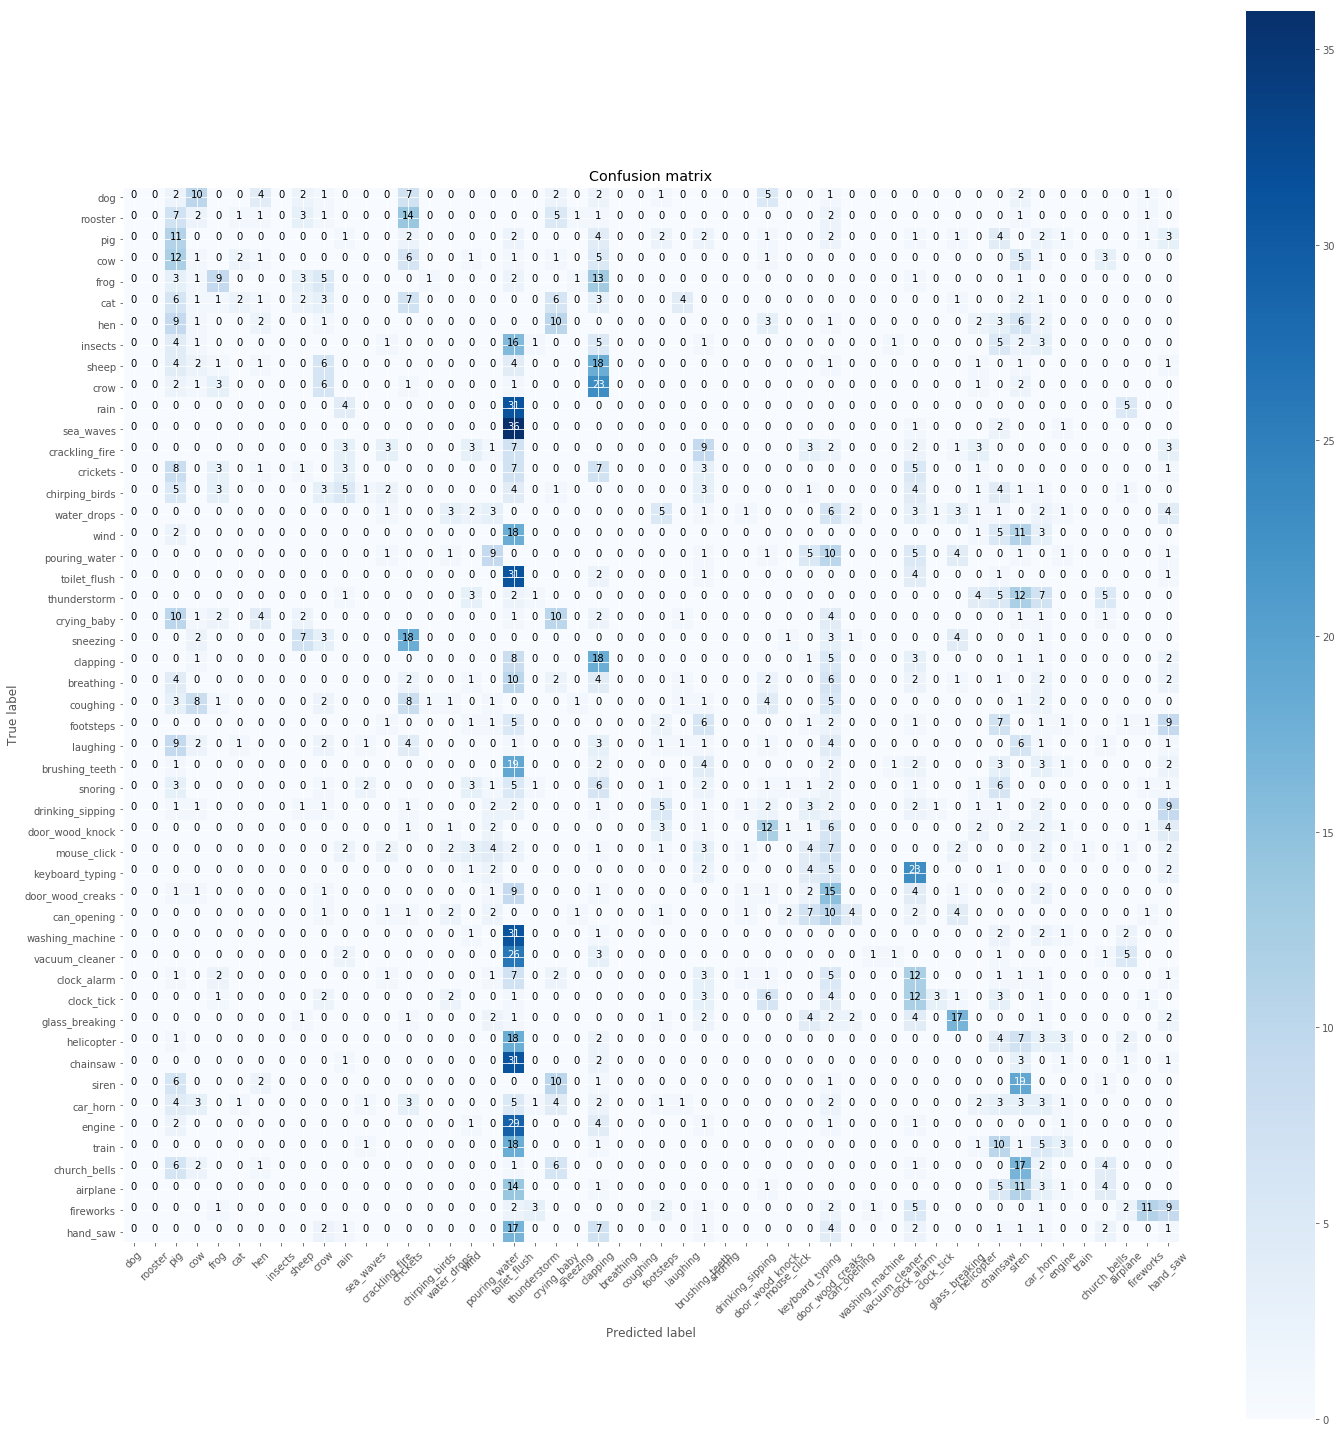

In [56]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

filename      1-100032-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                100032
take                         A
h_category                   0
Name: 0, dtype: object


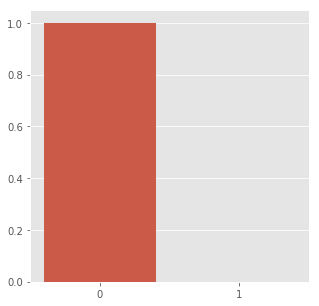

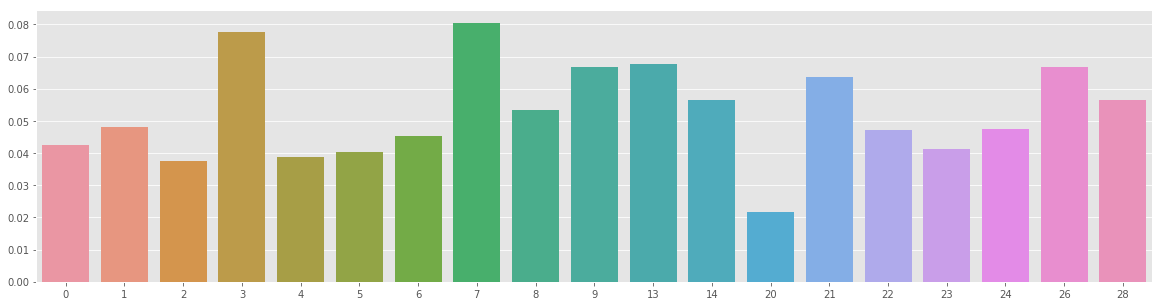

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


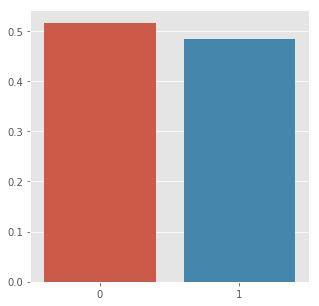

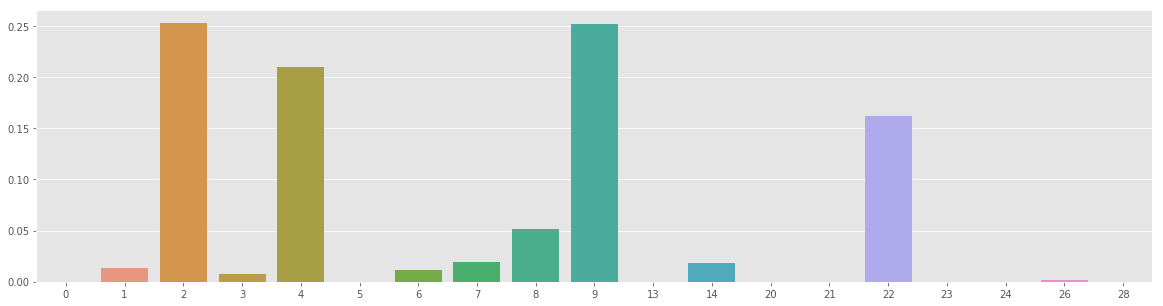

filename      1-100210-A-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          A
h_category                    1
Name: 2, dtype: object


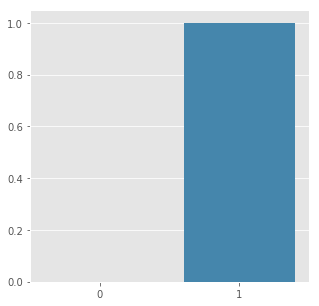

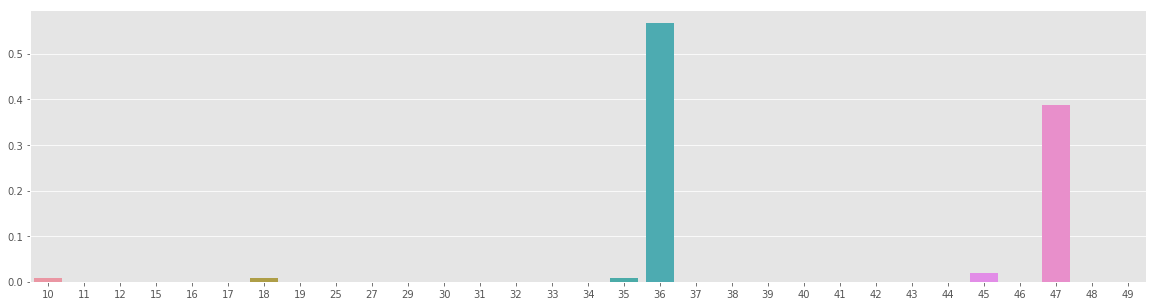

filename      1-100210-B-36.wav
fold                          1
target                       36
category         vacuum_cleaner
esc10                     False
src_file                 100210
take                          B
h_category                    1
Name: 3, dtype: object


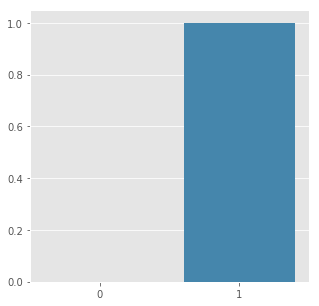

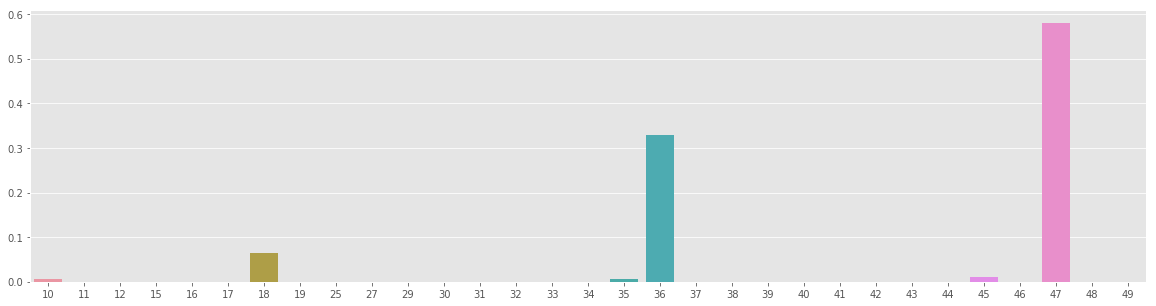

filename      1-101296-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          A
h_category                    1
Name: 4, dtype: object


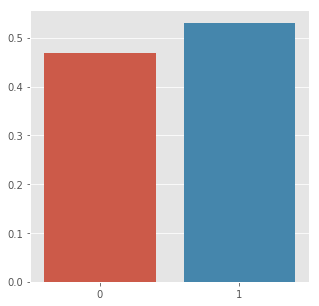

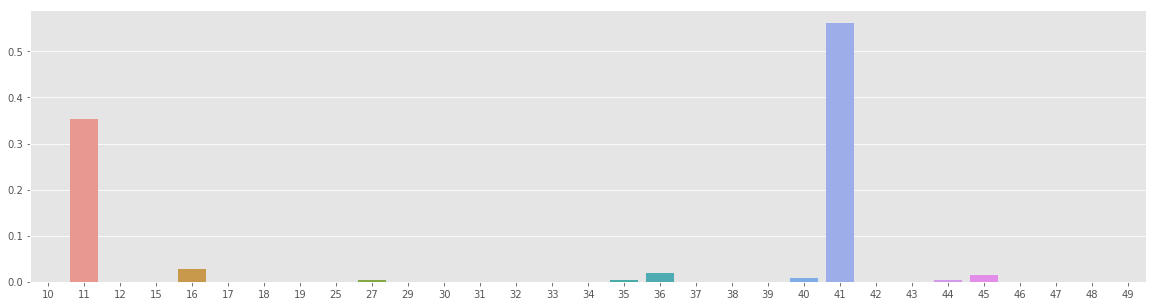

filename      1-101296-B-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 101296
take                          B
h_category                    1
Name: 5, dtype: object


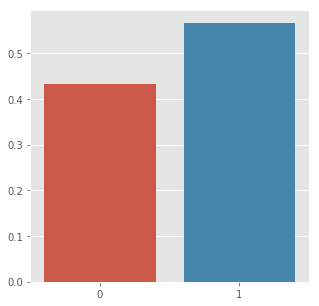

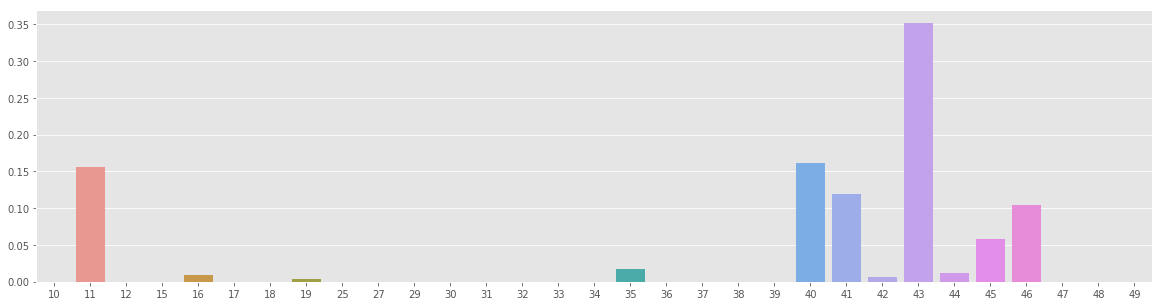

filename      1-101336-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 101336
take                          A
h_category                    1
Name: 6, dtype: object


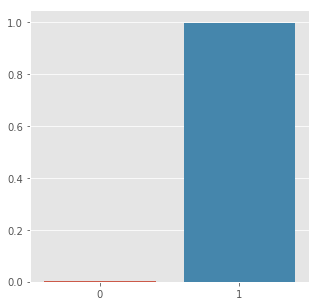

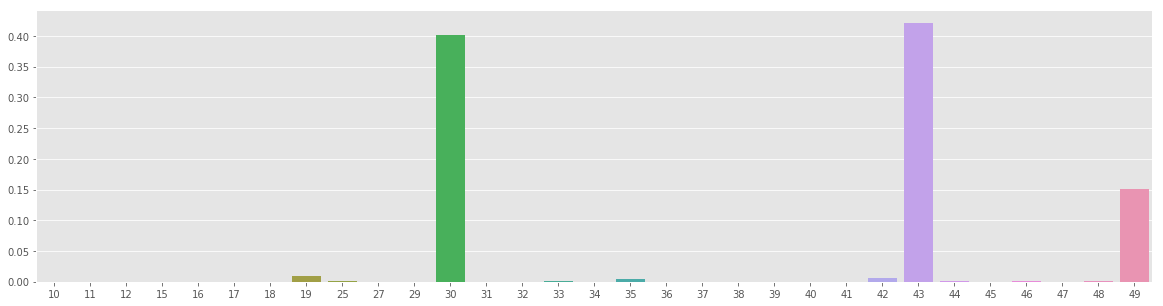

filename      1-101404-A-34.wav
fold                          1
target                       34
category            can_opening
esc10                     False
src_file                 101404
take                          A
h_category                    1
Name: 7, dtype: object


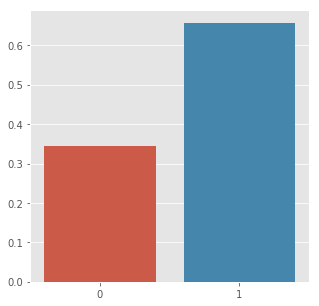

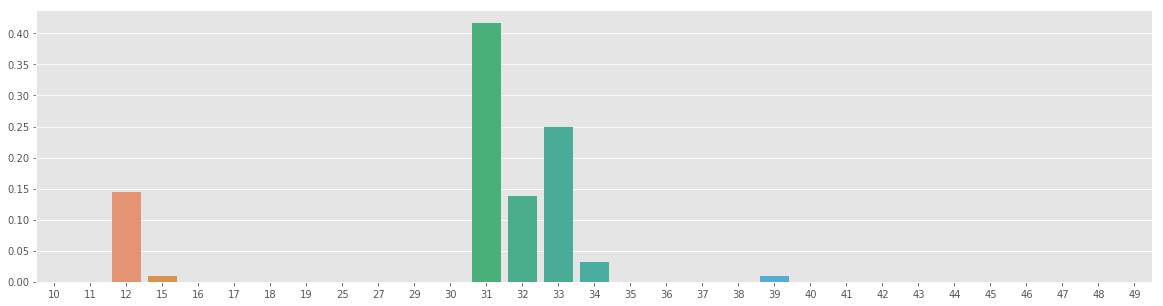

filename      1-103298-A-9.wav
fold                         1
target                       9
category                  crow
esc10                    False
src_file                103298
take                         A
h_category                   0
Name: 8, dtype: object


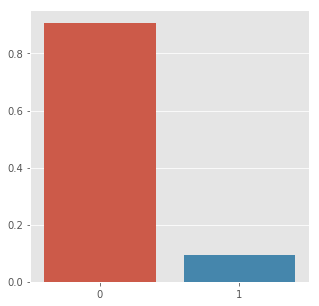

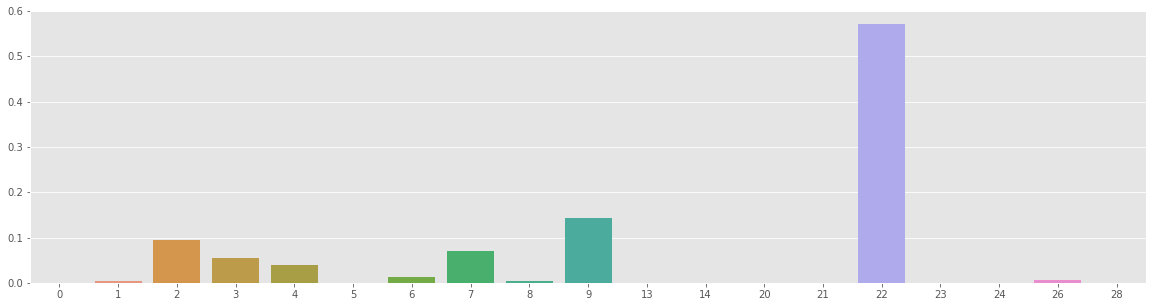

filename      1-103995-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103995
take                          A
h_category                    1
Name: 9, dtype: object


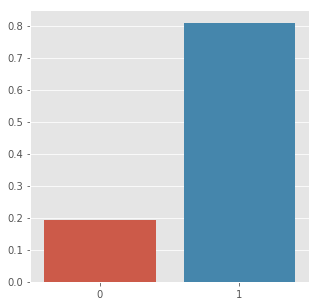

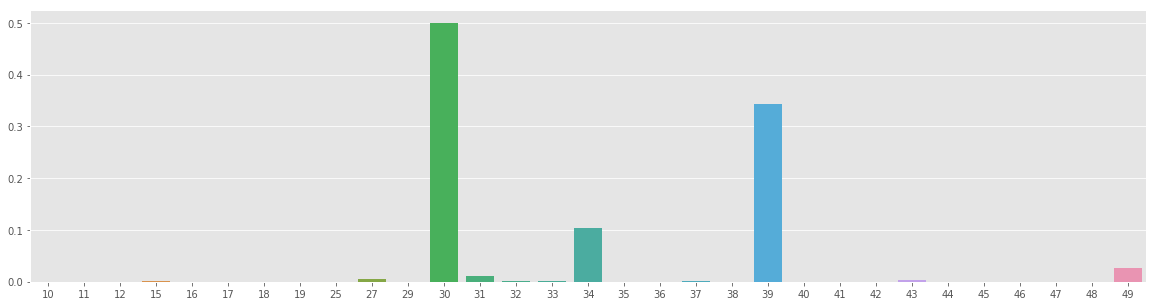

filename      1-103999-A-30.wav
fold                          1
target                       30
category        door_wood_knock
esc10                     False
src_file                 103999
take                          A
h_category                    1
Name: 10, dtype: object


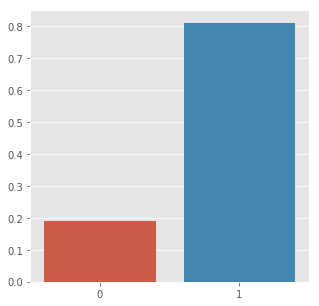

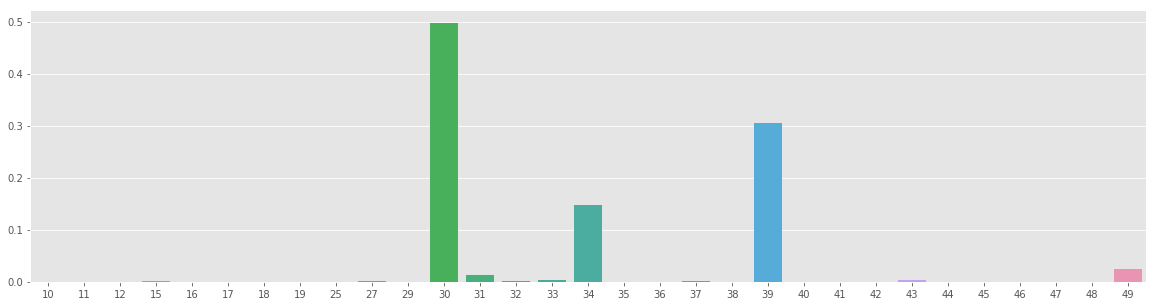

filename      1-104089-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          A
h_category                    0
Name: 11, dtype: object


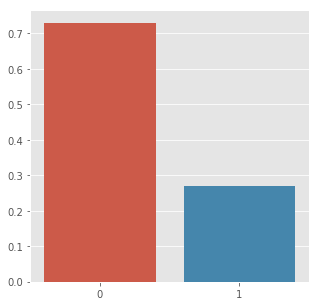

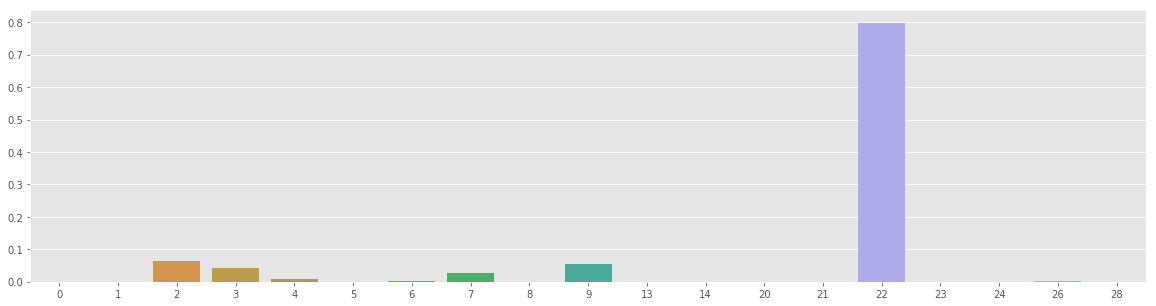

filename      1-104089-B-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 104089
take                          B
h_category                    0
Name: 12, dtype: object


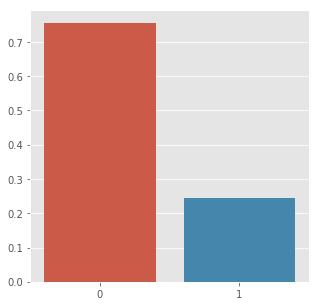

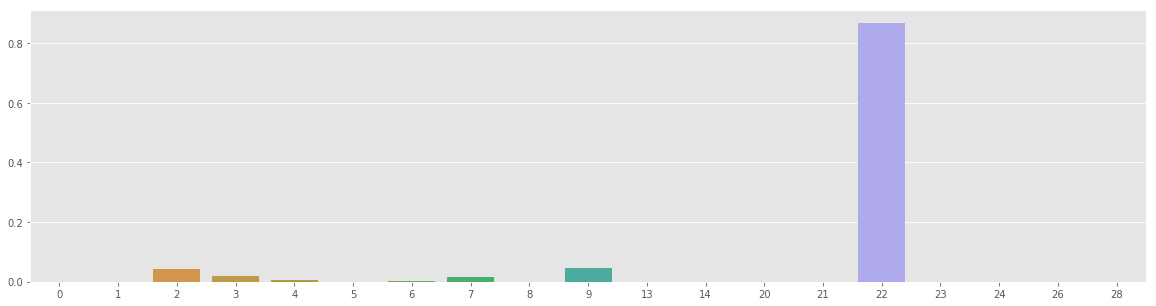

filename      1-105224-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 105224
take                          A
h_category                    0
Name: 13, dtype: object


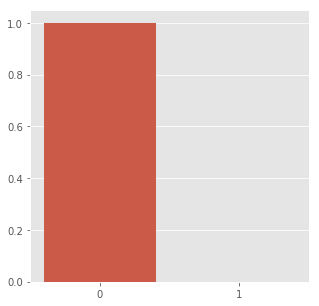

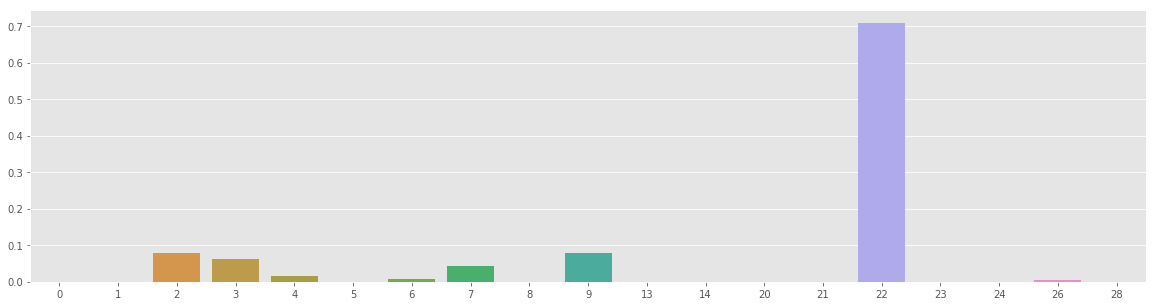

filename      1-110389-A-0.wav
fold                         1
target                       0
category                   dog
esc10                     True
src_file                110389
take                         A
h_category                   0
Name: 14, dtype: object


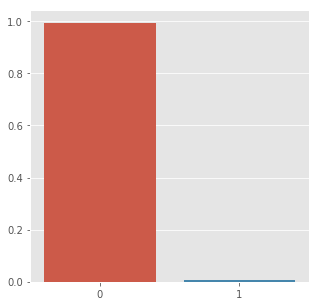

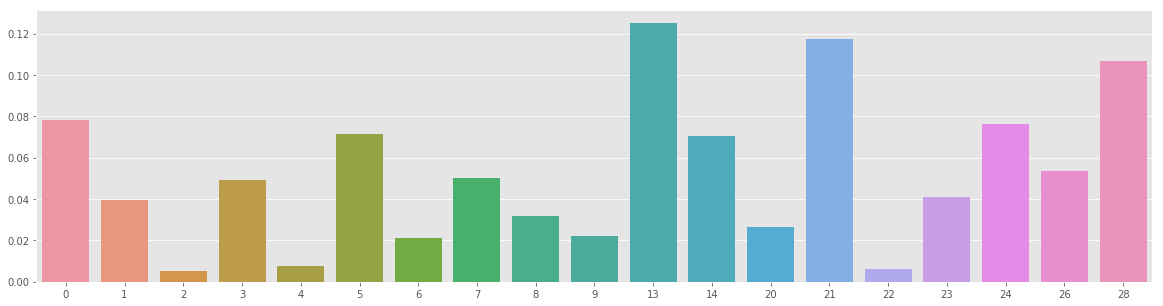

filename      1-110537-A-22.wav
fold                          1
target                       22
category               clapping
esc10                     False
src_file                 110537
take                          A
h_category                    0
Name: 15, dtype: object


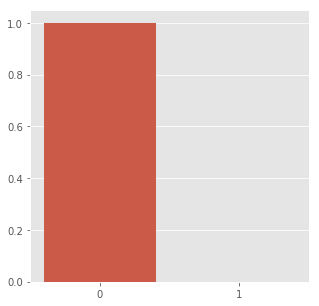

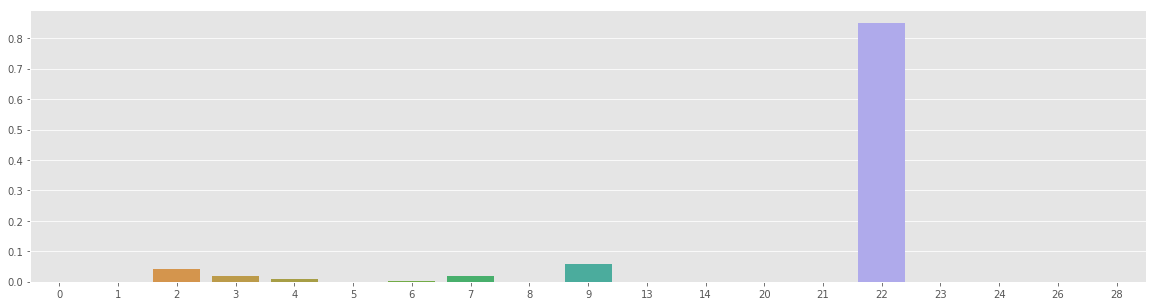

filename      1-115521-A-19.wav
fold                          1
target                       19
category           thunderstorm
esc10                     False
src_file                 115521
take                          A
h_category                    1
Name: 16, dtype: object


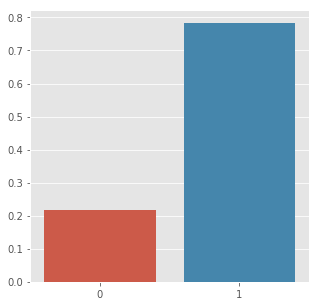

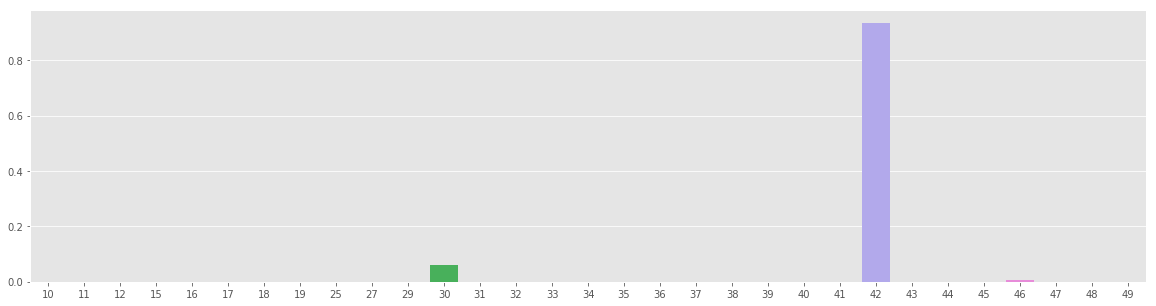

filename      1-115545-A-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          A
h_category                    1
Name: 17, dtype: object


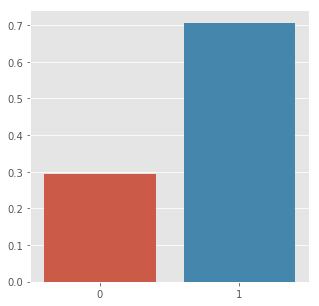

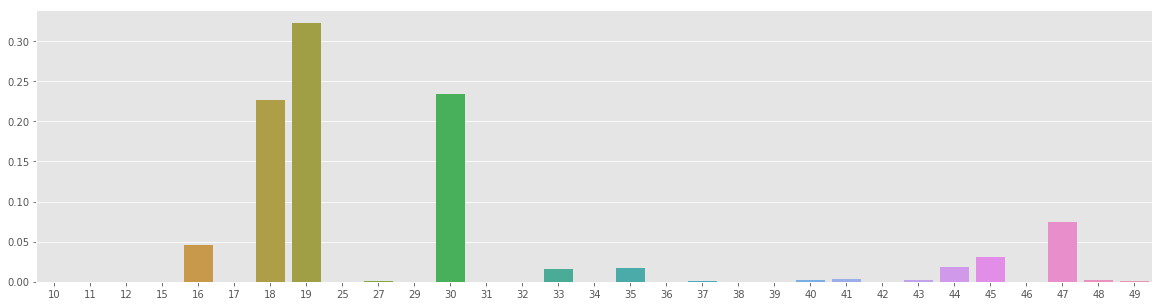

filename      1-115545-B-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          B
h_category                    1
Name: 18, dtype: object


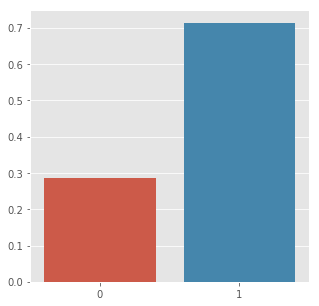

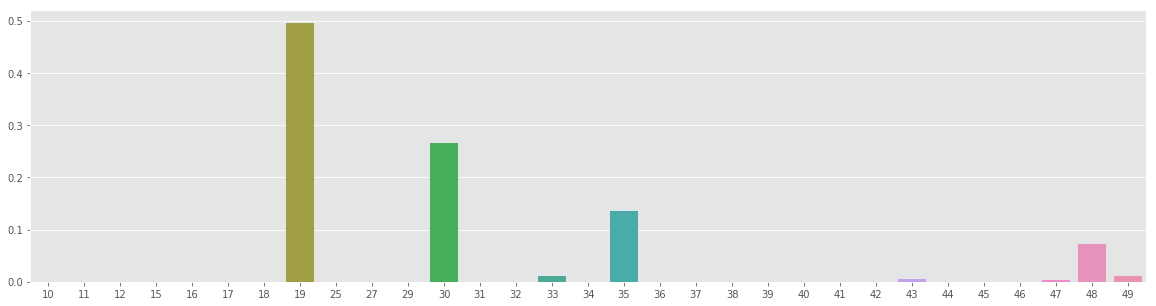

filename      1-115545-C-48.wav
fold                          1
target                       48
category              fireworks
esc10                     False
src_file                 115545
take                          C
h_category                    1
Name: 19, dtype: object


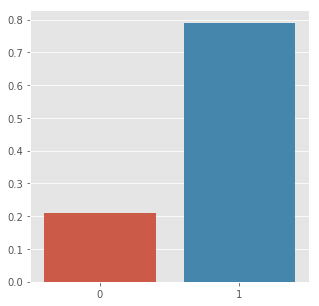

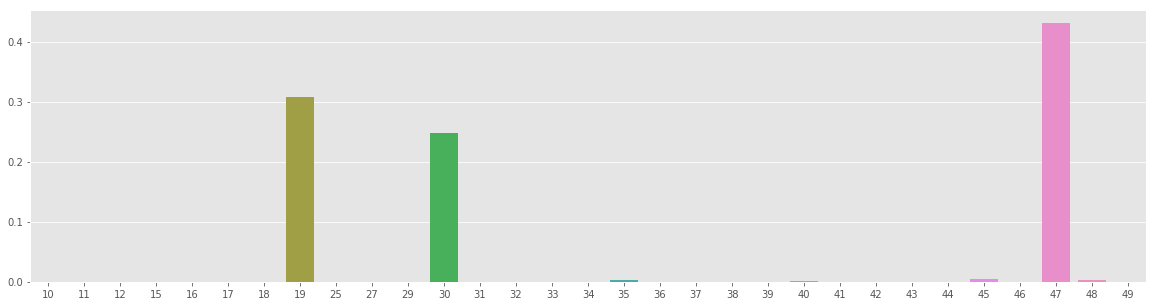

In [57]:
import seaborn as sns

for i in range(0,20):
    prob = pred_probs[i]
    print(dataset.iloc[i])

    xs = np.unique(targets)
    ys = np.average(top_pred_probs[i], axis=0)

    plt.figure(figsize=(5,5))
    sns.barplot(xs, ys)
    
    xs = np.unique(a_targ)
    ys = np.average(prob, axis=0)
    if(len(ys)!=len(xs)):
        xs = np.unique(i_targ)

    plt.figure(figsize=(20,5))
    sns.barplot(xs, ys)
    plt.show()